In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Load data

In [2]:
# Read pickle data
file_path = "vs_profiles.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

# Extract the data from dictionary
Vs_data_array = []

for key in data.keys():
    Vs_data_array.append(data[key][1])

In [3]:
from torch.nn.utils.rnn import pad_sequence
# Find the maximum length of the Vs data
max_length = max(len(vs_data) for vs_data in Vs_data_array)
print(f"Maximum length of Vs data: {max_length}")

# Pad the sequences to the maximum length
Vs_data_padded = pad_sequence([torch.tensor(vs_data,dtype=torch.float32) for vs_data in Vs_data_array], batch_first=True, padding_value=0.0)

Maximum length of Vs data: 4519


In [4]:
# CHeck Nans in the data
print(f"Number of NaNs in Vs_data_padded: {torch.isnan(Vs_data_padded).sum().item()}")

Number of NaNs in Vs_data_padded: 0


In [ ]:

class Vs_data(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Create a dataset and dataloader
dataset = Vs_data(Vs_data_padded)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
batch_size = 32

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 1895
Validation set size: 236
Test set size: 238


In [6]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder
        # Maps the input to the parameters of the latent distribution (mean and log-variance)
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)        # Output mean
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)    # Output log-variance

        # Decoder
        # Maps a sample from the latent space back to the original data space
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.decoder_fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """
        Encodes the input data x into the latent space distribution parameters.
        """
        h = F.relu(self.encoder_fc1(x))
        h = F.relu(self.encoder_fc2(h))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        # Clamp
        log_var = torch.clamp(log_var, min=-10, max=10)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Applies the reparameterization trick to sample from the latent distribution.
        z = mu + std * epsilon, where epsilon is sampled from N(0, 1)
        """
        std = torch.exp(0.5 * log_var)
        # Sample epsilon from standard normal distribution
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        return z

    def decode(self, z):
        """
        Decodes a latent vector z back into the data space.
        """
        h = F.relu(self.decoder_fc1(z))
        h = F.relu(self.decoder_fc2(h))
        # The final activation depends on the data type.
        # For unbounded continuous data, no activation or linear.
        # For data bounded between 0 and 1 (like normalized pixel values), sigmoid is common.
        # Here we assume potentially unbounded 1D data, so use linear activation.
        x_recon = self.decoder_fc3(h)
        return x_recon

    def forward(self, x):
        """
        Forward pass through the VAE.
        Encodes, reparameterizes, and decodes.
        Returns reconstructed output and the latent distribution parameters (mu, log_var)
        needed for the loss calculation.
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

    def generate(self, num_samples):
        """
        Generates new data samples by sampling from the prior latent distribution
        and decoding.
        """
        # Sample latent vectors from the standard normal prior
        z = torch.randn(num_samples, self.latent_dim).to(self.fc_mu.weight.device)
        # Decode the latent vectors
        generated_data = self.decode(z)
        return generated_data


In [7]:
# Define the VAE Loss Function
# The loss is the sum of the reconstruction loss and the KL divergence loss.
# We want to minimize the negative ELBO, which is equivalent to minimizing
# Reconstruction Loss + KL Divergence.

def vae_loss(x_recon, x, mu, log_var, mask):
    """
    Calculates the VAE loss (negative ELBO) while ignoring padded values.

    Args:
        x_recon (torch.Tensor): The reconstructed data from the decoder.
        x (torch.Tensor): The original input data.
        mu (torch.Tensor): The mean of the latent distribution from the encoder.
        log_var (torch.Tensor): The log-variance of the latent distribution from the encoder.
        mask (torch.Tensor): A binary mask indicating non-padded values (1 for valid, 0 for padded).

    Returns:
        torch.Tensor: The total VAE loss for the batch.
        torch.Tensor: The reconstruction loss for the batch.
        torch.Tensor: The KL divergence loss for the batch.
    """
    # Apply the mask to ignore padded values in the reconstruction loss
    reconstruction_loss = F.mse_loss(x_recon * mask, x * mask, reduction='sum') / mask.sum()

    # KL divergence loss (unchanged, as it applies to the latent space)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)

    # Total VAE loss (negative ELBO)
    total_loss = reconstruction_loss + kl_divergence

    return total_loss, reconstruction_loss, kl_divergence

In [8]:
# Hyperparameters
input_dimension = max_length  # Dimension of your 1D array
hidden_dimension = 256 # Dimension of hidden layers
latent_dimension = 200  # Dimension of the latent space
learning_rate = 1e-3
epochs = 500

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the VAE model, optimizer
model = VAE(input_dimension, hidden_dimension, latent_dimension).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"VAE model initialized with:")
print(f"  Input Dimension: {input_dimension}")
print(f"  Hidden Dimension: {hidden_dimension}")
print(f"  Latent Dimension: {latent_dimension}")

Using device: cuda
VAE model initialized with:
  Input Dimension: 4519
  Hidden Dimension: 256
  Latent Dimension: 200


In [9]:
# Training loop with validation
print("Starting training with validation...")
model.train()  # Set model to training mode

# Store the losses
train_losses = []
val_losses = []
train_recon_losses = []
val_recon_losses = []
train_kl_losses = []
val_kl_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_recon_loss = 0
    total_train_kl_loss = 0

    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        mask = (batch_data != 0).float().to(device)
        
        if mask.sum() == 0:
            print("Warning: Mask contains all zeros. Skipping this batch.")
            assert False, "Mask contains all zeros. Check your data."

        if torch.isnan(batch_data).any() or torch.isinf(batch_data).any():
            print("Invalid values detected in batch_data. Skipping this batch.")
            continue

        # Forward pass
        x_recon, mu, log_var = model(batch_data)

        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(x_recon, batch_data, mu, log_var, mask)

        if (loss.isnan().any() or recon_loss.isnan().any() or kl_loss.isnan().any()):
            print("NaN detected in loss calculations. Skipping this batch.")
            continue

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_recon_loss += recon_loss.item()
        total_train_kl_loss += kl_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_recon_loss = total_train_recon_loss / len(train_loader)
    avg_train_kl_loss = total_train_kl_loss / len(train_loader)

    train_losses.append(avg_train_loss)
    train_recon_losses.append(avg_train_recon_loss)
    train_kl_losses.append(avg_train_kl_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    total_val_recon_loss = 0
    total_val_kl_loss = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_data in val_loader:
            batch_data = batch_data.to(device)
            mask = (batch_data != 0).float().to(device)  # Generate the mask

            # Forward pass
            x_recon, mu, log_var = model(batch_data)

            # Compute loss
            loss, recon_loss, kl_loss = vae_loss(x_recon, batch_data, mu, log_var, mask)

            total_val_loss += loss.item()
            total_val_recon_loss += recon_loss.item()
            total_val_kl_loss += kl_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_recon_loss = total_val_recon_loss / len(val_loader)
    avg_val_kl_loss = total_val_kl_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    val_recon_losses.append(avg_val_recon_loss)
    val_kl_losses.append(avg_val_kl_loss)

    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_train_recon_loss:.4f}, KL Loss: {avg_train_kl_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Recon Loss: {avg_val_recon_loss:.4f}, KL Loss: {avg_val_kl_loss:.4f}")

print("Training with validation finished.")

Starting training with validation...
Epoch [1/500], Train Loss: 1083195.4905, Recon Loss: 882448.6031, KL Loss: 200746.8940, Val Loss: 1391235.8633, Recon Loss: 915437.8633, KL Loss: 475797.9717
Epoch [2/500], Train Loss: 659351.8774, Recon Loss: 330585.7207, KL Loss: 328766.1518, Val Loss: 774959.9785, Recon Loss: 287343.2769, KL Loss: 487616.6826
Epoch [3/500], Train Loss: 769561.3352, Recon Loss: 505494.0923, KL Loss: 264067.2477, Val Loss: 625869.2305, Recon Loss: 275286.1904, KL Loss: 350583.0513
Epoch [4/500], Train Loss: 987152.8251, Recon Loss: 692865.5652, KL Loss: 294287.2590, Val Loss: 593688.5215, Recon Loss: 267007.1074, KL Loss: 326681.4233
Epoch [5/500], Train Loss: 1441607.5464, Recon Loss: 941862.0482, KL Loss: 499745.5121, Val Loss: 1186477.5762, Recon Loss: 1074337.0615, KL Loss: 112140.5249
Epoch [6/500], Train Loss: 666889.4904, Recon Loss: 522601.1943, KL Loss: 144288.2996, Val Loss: 472330.3965, Recon Loss: 206222.4531, KL Loss: 266107.9443
Epoch [7/500], Train L

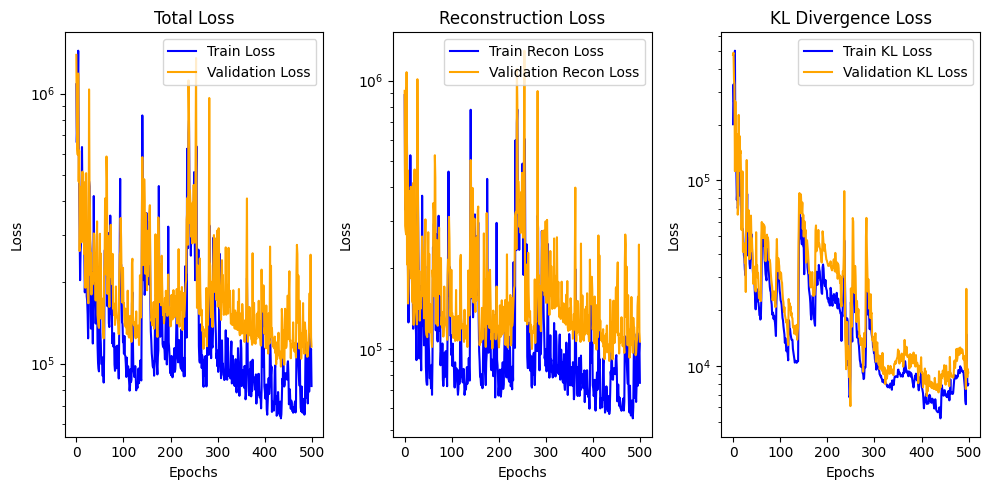

In [10]:
# Plotting the training and validation losses
fig, ax = plt.subplots(1,3, figsize=(10, 5))

ax[0].plot(train_losses, label='Train Loss', color='blue')
ax[0].plot(val_losses, label='Validation Loss', color='orange')
ax[0].set_title('Total Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_recon_losses, label='Train Recon Loss', color='blue')
ax[1].plot(val_recon_losses, label='Validation Recon Loss', color='orange')
ax[1].set_title('Reconstruction Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(train_kl_losses, label='Train KL Loss', color='blue')
ax[2].plot(val_kl_losses, label='Validation KL Loss', color='orange')
ax[2].set_title('KL Divergence Loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend()

# All y axis in log scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

plt.tight_layout()
plt.show()


Generating new data samples...
Generated 5 samples:
Sample 1 (first 10 elements): [33.40689  33.050488 36.060944 34.466747 37.670425 37.703117 38.65928
 38.7099   37.24221  39.293247]
Sample 2 (first 10 elements): [39.602646 38.437584 43.00009  44.94924  48.197533 50.247963 49.59795
 50.649803 51.24717  53.069504]
Sample 3 (first 10 elements): [47.527756 47.091103 51.287994 51.68576  55.652008 57.894707 57.321438
 58.321133 58.254654 60.489113]
Sample 4 (first 10 elements): [44.183884 42.767696 44.37452  44.48786  46.771545 46.749855 46.10963
 45.628098 45.55905  47.208008]
Sample 5 (first 10 elements): [46.10814  44.26376  44.225636 44.24803  45.617317 45.938087 46.74123
 46.439537 48.230095 50.41568 ]


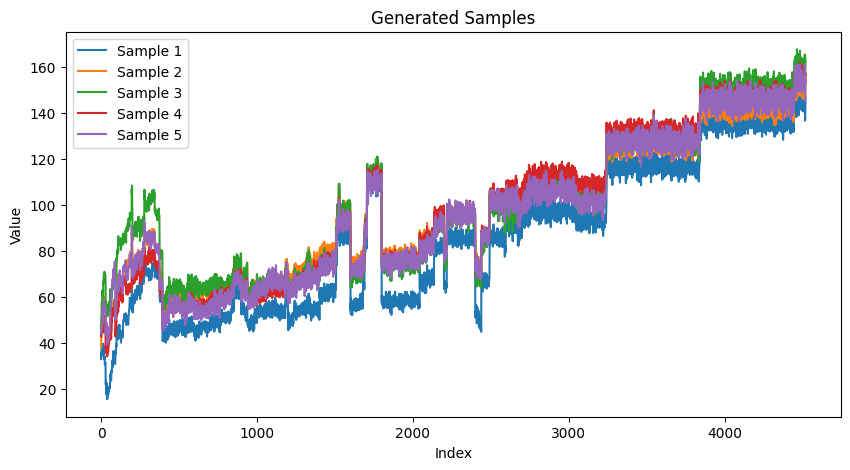

In [11]:
# --- Improved Generation Example ---
print("\nGenerating new data samples...")
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    num_samples_to_generate = 5
    generated_samples = model.generate(num_samples_to_generate)

# Convert generated samples to numpy arrays for easier visualization
generated_samples_np = [sample.cpu().numpy() for sample in generated_samples]

# Print all generated samples
print(f"Generated {num_samples_to_generate} samples:")
for i, sample in enumerate(generated_samples_np):
    print(f"Sample {i + 1} (first 10 elements): {sample[:10]}")

# Optional: Visualize the generated samples
plt.figure(figsize=(10, 5))
for i, sample in enumerate(generated_samples_np):
    plt.plot(sample, label=f"Sample {i + 1}")
plt.title("Generated Samples")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()